In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Read in Shapefile
shp_path = "shapefiles/India_Districts_ADM2_GADM.shp"
sf = shp.Reader(shp_path)

In [3]:
def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe
    
    Args:
        sf: pyshp shapefile
        
    Returns:
        df: Pandas dataframe with a 'coords' column
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    
    return df

In [4]:
# Data Frame generated from our Shapefile
df = read_shapefile(sf)

In [5]:
def filter_dataframe(dataframe, search_col, query):
    """
    Filters a pandas dataframe and returns a new dataframe based
    on a query.
    
    Args:
        dataframe : pandas dataframe
            Unfiltered pandas dataframe.
        
        search_col : str
            Column field we are filtering by.
            ex. 'State/UnionTerritory' for covid_19_india.csv
        
        query : str
            value to be searched for i.e. 'Tripura.'
        
    Returns:
        dataframe : New dataframe filtered by the column field
                    and query.
    """
    conditional = dataframe[search_col] == query
    filtered = dataframe[conditional]
    
    return filtered

In [6]:
def extract_state_coordinates(state_df):
    """
    Calculates the average coordinates for a state based on all
    of its districts.
    
    Args:
        state_df: A filtered dataframe containing all district entries
                  for a given state.
    Returns:
        tuple:    A tuple containing the mean Longitude and Lattitude
                  of a state
    """
    # Reset the index to make iterating easier
    state_df.reset_index(drop=True)
    x0 = 0
    y0 = 0
    # Iterate through each district of the state
    for i in range(state_df.shape[0]):
        # District shape
        shape_ex = sf.shape(state_df.index[i])
        x_lon = np.zeros((len(shape_ex.points),1))
        y_lat = np.zeros((len(shape_ex.points),1))
        for ip in range(len(shape_ex.points)):
            x_lon[ip] = shape_ex.points[ip][0]
            y_lat[ip] = shape_ex.points[ip][1]
        # Calculate the mean long and lat for each diistrict
        x0 += np.mean(x_lon)/state_df.shape[0]
        y0 += np.mean(y_lat)/state_df.shape[0]

    # Return mean long and lat for the state
    return x0, y0

In [7]:
# Read in the CSV files into dataframes
covid_df = pd.read_csv("covid_19_india.csv")
tests_df = pd.read_csv("StatewiseTestingDetails.csv")

# Filter the dataframes by date and reset the index
covid_ft = filter_dataframe(covid_df, "Date", "16/11/20")
covid_ft = covid_ft.reset_index(drop=True)
tests_ft = filter_dataframe(tests_df, "Date", "2020-11-15")

In [8]:
# Update the test_ft data frame to account for the edge cases
Dadra = filter_dataframe(filter_dataframe(tests_df, "State", "Dadra and Nagar Haveli and Daman and Diu"),"Date", "2020-10-20")
tests_ft = tests_ft.append(Dadra,ignore_index=True)
Maharashtra = filter_dataframe(filter_dataframe(tests_df, "State", "Maharashtra"),"Date", "2020-11-13")
tests_ft = tests_ft.append(Maharashtra,ignore_index=True)
Manipur = filter_dataframe(filter_dataframe(tests_df, "State", "Manipur"),"Date", "2020-11-14")
tests_ft = tests_ft.append(Manipur,ignore_index=True)
Meghalaya = filter_dataframe(filter_dataframe(tests_df, "State", "Meghalaya"),"Date", "2020-11-14")
tests_ft = tests_ft.append(Meghalaya,ignore_index=True)

# Sort the updated dataframe by state and reset the index
tests_ft = tests_ft.sort_values(by=['State'])
tests_ft = tests_ft.reset_index(drop=True)

In [9]:
# Numpy Arrays used to plot the histogram
Lons = np.zeros(35, dtype=float)          # Longitudes
Lats = np.zeros(35, dtype=float)          # Latitudes
InfectionRatio = np.zeros(35, dtype=float) # Confirmed Cases / Test Results

In [10]:
# Populate our arrays
for i in range(35):
    # Retrieve the shapefile
    curr_state_name = tests_ft.iloc[i]['State']
    # Deal with edge cases
    if (curr_state_name == "Andaman and Nicobar Islands"):
        curr_state_name = 'Andaman and Nicobar'
    elif (curr_state_name == "Dadra and Nagar Haveli and Daman and Diu"):
        curr_state_name = 'Dadra and Nagar Haveli'
        curr_state_df = filter_dataframe(df, 'NAME_1', curr_state_name)
        curr_coords = extract_state_coordinates(curr_state_df)
        Lons[i] = curr_coords[0] / 2
        Lats[i] = curr_coords[1] / 2
        curr_ratio = covid_ft.iloc[i]['Confirmed'] / tests_ft.iloc[i]['TotalSamples']
        InfectionRatio[i] = curr_ratio
        curr_state_name = 'Daman and Diu'
        curr_state_df = filter_dataframe(df, 'NAME_1', curr_state_name)
        curr_coords = extract_state_coordinates(curr_state_df)
        Lons[i] += curr_coords[0] / 2
        Lats[i] += curr_coords[1] / 2
        curr_ratio = covid_ft.iloc[i]['Confirmed'] / tests_ft.iloc[i]['TotalSamples']
        InfectionRatio[i] += curr_ratio
        continue
    elif (curr_state_name == "Odisha"):
        curr_state_name = 'Orissa'
    elif (curr_state_name == "Uttarakhand"):
        curr_state_name = 'Uttaranchal'
    elif ((curr_state_name == "Ladakh") or (curr_state_name == "Telangana")):
        continue
    curr_state_df = filter_dataframe(df, 'NAME_1', curr_state_name)
    # Extract the coordinates
    curr_coords = extract_state_coordinates(curr_state_df)
    # Update our position arrays
    Lons[i] = curr_coords[0]
    Lats[i] = curr_coords[1]
    # Calculate Infection Ratio
    curr_ratio = covid_ft.iloc[i]['Confirmed'] / tests_ft.iloc[i]['TotalSamples']
    # Update our Infection Array
    InfectionRatio[i] = curr_ratio

In [11]:
def three_dimensional_histogram(longitudes, latitudes, data, lbound, ubound, title, zaxis):
    """
    Creates and plots a 3D histogram plot, overlayed
    on a map of India based on our data.
    
    Args:
        longitudes: numpy array of floats
        latitudes:  numpy array of floats
        data:       numpy array of floats
        lbound:     float, lower-bound of data values
        ubound:     float, upper-bound of data values
        title:      str representing the plot title
        zaxis:      str representing the z-axis label
        
    Returns:
        Void
    """
    # Initializing and centering our map on India
    map = Basemap(llcrnrlon=68.5,llcrnrlat=5.,urcrnrlon=99.5,urcrnrlat=36., lat_0 = 20.5, lon_0 = 84, fix_aspect=False)

    # Initializing the plot
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_autoscale_on(True)
    ax.set_autoscalez_on(True)
    ax.set_title(title)
    ax.set_zbound(lower=lbound, upper=ubound)
    ax.set_zlabel(zaxis)
    
    # Draw the coastline and the country
    ax.add_collection3d(map.drawcoastlines(linewidth=0.25))
    ax.add_collection3d(map.drawcountries(linewidth=0.35))
    
    x, y = map(longitudes, latitudes)
    ax.bar3d(x,y, np.zeros(len(x)), 1, 1, data, color = 'r', alpha = 1.0)
    plt.show()

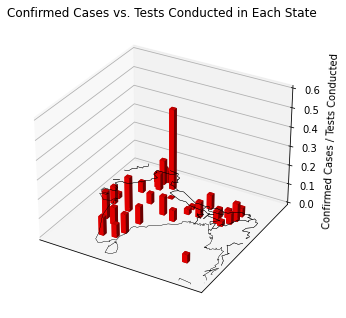

In [12]:
three_dimensional_histogram(Lons, Lats, InfectionRatio, 0.0, 0.6,'Confirmed Cases vs. Tests Conducted in Each State','Confirmed Cases / Tests Conducted')

In [13]:
# https://censusindia.gov.in/2011-prov-results/data_files/india/Final_PPT_2011chapter7.pdf
PopulationDensity = np.array([46,308,17,397,1102,9252,189,698,11297,394,308,573,123,124,414,319,859,0,236,365,122,132,52,119,269,2598,550,201,86,555,0,350,828,189,1029])


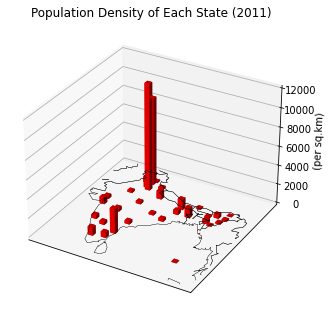

In [14]:
# Population Density per State - From 2011
three_dimensional_histogram(Lons, Lats, PopulationDensity, 0.0, 12000.0, 'Population Density of Each State (2011)', '(per sq.km)')